In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn.metrics as metrics
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Autoreload file containing helper functions
%load_ext autoreload
%autoreload 2
import data_processing

## Load Data

In [51]:
# Load project data and set index as project id
x_df = data_processing.load_data('data/projects.csv', 'projectid')

In [52]:
# Load outcome data and set index as project id, add binary outcome variable
y_df = df = data_processing.load_data('data/outcomes.csv', 'projectid')
y_df['outcome'] = np.where(y_df['fully_funded']=='t', 1, 0)

In [53]:
# Merge outcome feature dataframe
full_df = x_df.merge(y_df, left_index = True, right_index = True)

In [54]:
# Drop extraneous data from outcome frame that could cause leakage into outcome variable
drop_cols = ['is_exciting', 'at_least_1_teacher_referred_donor',
             'at_least_1_green_donation', 'great_chat',
             'three_or_more_non_teacher_referred_donors',
             'one_non_teacher_referred_donor_giving_100_plus',
             'donation_from_thoughtful_donor', 'great_messages_proportion',
             'teacher_referred_count', 'non_teacher_referred_count', 
             'projectid_y', 'fully_funded']
full_df.drop(drop_cols, axis = 1, inplace = True)

In [70]:
# Filter for 2011 thorough 2013
full_df['date_posted'] = pd.to_datetime(full_df['date_posted'])
full_df = full_df[(full_df['date_posted'] > '2010-12-31') & (full_df['date_posted'] <'2014-01-01')]

## Data Exploration

In [71]:
# Observe data structure using "head" function
full_df.head()

,projectid_x,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,outcome
44772,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,...,moderate poverty,Grades 3-5,30.0,444.36,522.78,7.0,f,f,2013-12-31,1
44773,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,...,high poverty,Grades 3-5,30.0,233.24,274.40,30.0,f,f,2013-12-31,0
44774,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,...,moderate poverty,Grades 6-8,30.0,285.09,335.40,230.0,f,f,2013-12-31,1
44775,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,...,highest poverty,Grades PreK-2,30.0,232.94,274.05,18.0,f,f,2013-12-31,1
44776,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,...,highest poverty,Grades 6-8,30.0,513.41,604.01,70.0,t,f,2013-12-31,0


In [72]:
# Use "describe" to get broad understanding of range of values for each variable
full_df.describe()

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,outcome
count,3.282930e+05,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353050.000000,353151.000000
mean,2.503127e+11,36.868563,-95.398318,56301.763713,32.220311,531.372372,625.143964,94.187169,0.694810
std,1.648173e+11,4.927417,18.118360,31043.523511,2.484309,844.069364,993.022780,156.987405,0.460488
min,1.000050e+10,18.249140,-171.690554,410.000000,30.000000,37.030000,43.560000,1.000000,0.000000
25%,6.372301e+10,33.916387,-117.246823,29388.000000,30.000000,288.750000,339.710000,23.000000,0.000000
50%,2.400090e+11,36.675826,-89.886438,60613.000000,30.000000,427.270000,502.670000,31.000000,1.000000
75%,3.904440e+11,40.680488,-80.761902,90007.000000,35.000000,606.720000,713.790000,100.000000,1.000000
max,6.100008e+11,67.258157,-66.628036,99926.000000,35.000000,139725.410000,164382.840000,12143.000000,1.000000


### Commentary

xyz

In [75]:
# Define continuous and discrete variables
continuous_cols = ['fulfillment_labor_materials',
                   'total_price_excluding_optional_support',
                   'total_price_including_optional_support',]

discrete_cols = ['school_state', 'school_metro', 'outcome', 'school_charter', 
                 'school_magnet', 'school_year_round', 'school_nlns','school_kipp', 
                 'school_charter_ready_promise', 'teacher_prefix','teacher_teach_for_america', 
                 'teacher_ny_teaching_fellow','primary_focus_subject', 'primary_focus_area',
                 'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
                 'poverty_level', 'grade_level']

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


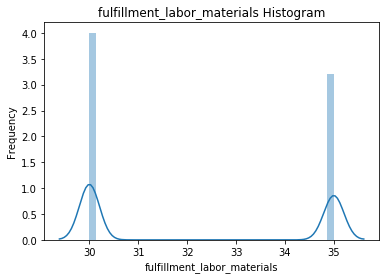

In [79]:
# Create histograms for continuous variables
data_processing.make_histogram(full_df, 'fulfillment_labor_materials')

What do 30 and 35 mean for fulfillment? Outliers

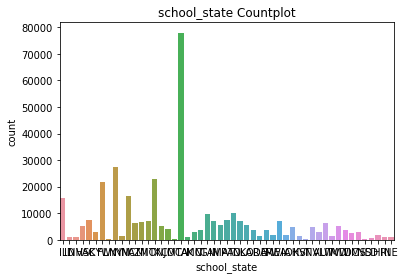

None


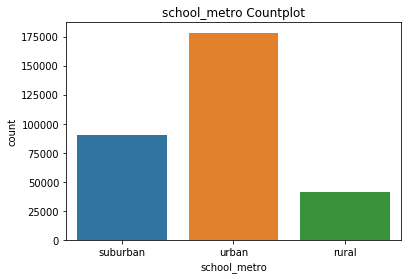

None


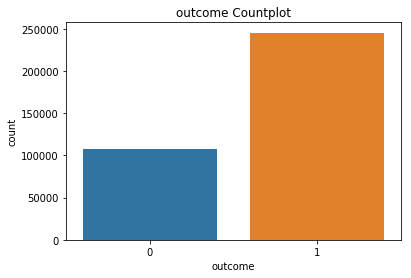

None


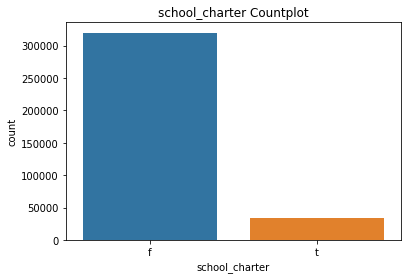

None


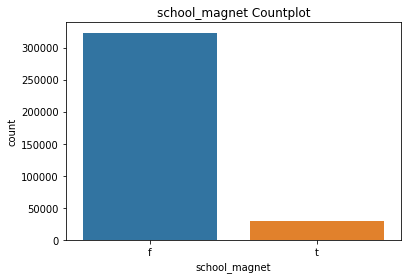

None


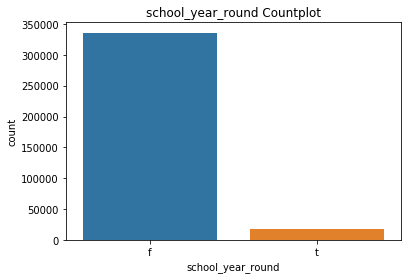

None


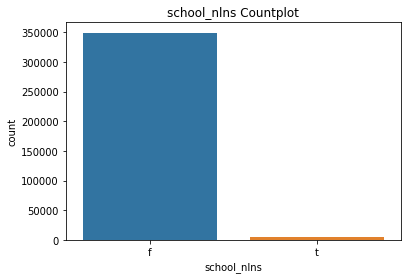

None


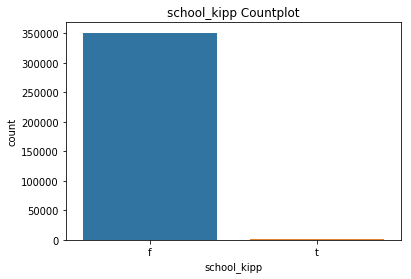

None


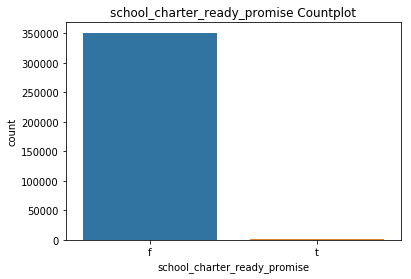

None


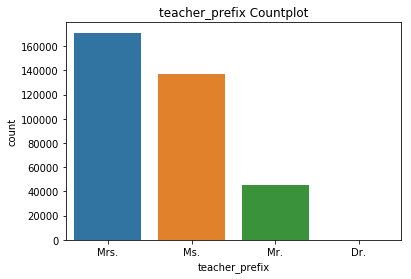

None


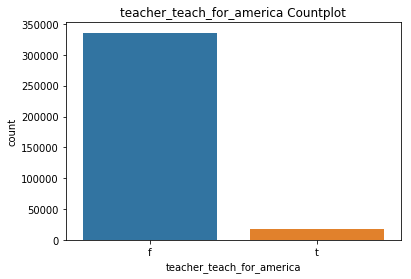

None


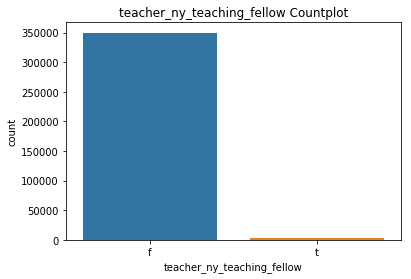

None


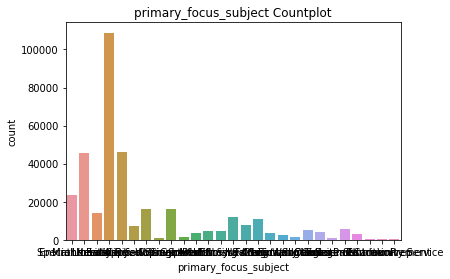

None


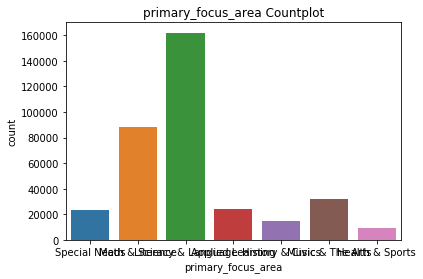

None


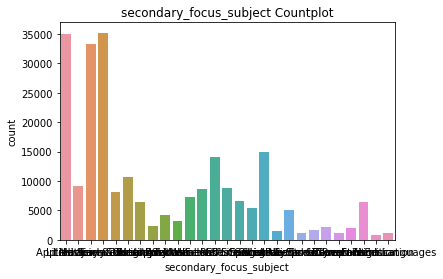

None


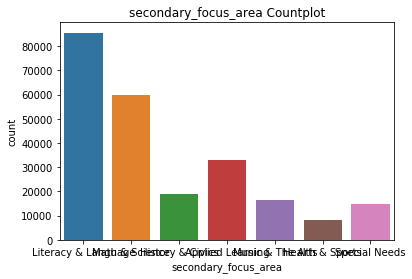

None


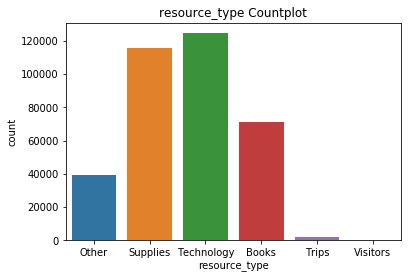

None


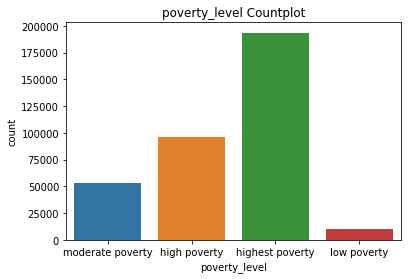

None


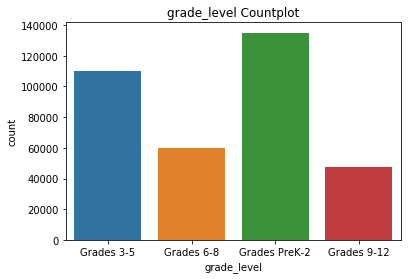

None


In [78]:
# Create countcharts for discrete variables
for col in discrete_cols:
    print(data_processing.make_countchart(full_df, col))

Need to dummify most of these. 

## Data Processing/Cleaning

## Generate Features/Predictors

## Build Classifier

## Evaluate Classifier